In [1]:
# from google.colab import drive

import json
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

In [2]:
# Connect Drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [60]:
# !wget http://images.cocodataset.org/zips/train2014.zip

--2023-07-17 23:37:56--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.52.49, 3.5.28.123, 54.231.171.233, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.52.49|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘train2014.zip’

train2014.zip       100%[===================>]  12.58G  53.0MB/s    in 3m 56s  

2023-07-17 23:41:51 (54.7 MB/s) - ‘train2014.zip’ saved [13510573713/13510573713]



In [63]:
# !unzip train2014.zip -d '/content/gdrive/MyDrive/0_Tugas Akhir/dataset'

Streaming output truncated to the last 5000 lines.
 extracting: /content/gdrive/MyDrive/0_Tugas Akhir/dataset/train2014/COCO_train2014_000000408557.jpg  
 extracting: /content/gdrive/MyDrive/0_Tugas Akhir/dataset/train2014/COCO_train2014_000000013714.jpg  
 extracting: /content/gdrive/MyDrive/0_Tugas Akhir/dataset/train2014/COCO_train2014_000000194043.jpg  
 extracting: /content/gdrive/MyDrive/0_Tugas Akhir/dataset/train2014/COCO_train2014_000000219859.jpg  
 extracting: /content/gdrive/MyDrive/0_Tugas Akhir/dataset/train2014/COCO_train2014_000000278135.jpg  
 extracting: /content/gdrive/MyDrive/0_Tugas Akhir/dataset/train2014/COCO_train2014_000000141015.jpg  
 extracting: /content/gdrive/MyDrive/0_Tugas Akhir/dataset/train2014/COCO_train2014_000000280923.jpg  
 extracting: /content/gdrive/MyDrive/0_Tugas Akhir/dataset/train2014/COCO_train2014_000000200024.jpg  
 extracting: /content/gdrive/MyDrive/0_Tugas Akhir/dataset/train2014/COCO_train2014_000000435713.jpg  
 extracting: /content/

# Fine-tune GIT on a custom dataset for image captioning

In this notebook, we'll fine-tune [GIT](https://huggingface.co/docs/transformers/main/en/model_doc/git), short for GenerativeImage2Text, on a toy image captioning dataset.

GIT is, at the moment of writing, a state-of-the-art image/video captioning and question answering (QA) model.

## Set-up environment

First, let's install 🤗 Transformers as well as 🤗 Datasets.

In [3]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.8 MB/s eta 0:00:00


In [4]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.5 MB/s eta 0:00:00


## Create image captioning dataset

Next, we'll create a tiny image captioning dataset, which as you might have guessed consists of (image, text) pairs.

As I'm a football fan I simply went to the Wikipedia page of a few of the most famous footballers, and took a captioned image from their respective pages.

We'll follow the guide [here](https://huggingface.co/docs/datasets/main/en/image_dataset#image-captioning) to create a 🤗 Dataset, which allows for very fast processing. Basically, we need to add a metadata.jsonl file to our folder containing the images. This metadata file contains the captions, for each of the images.

In [37]:
import json

json_file = 'coco_karpathy_train_indo.json'

# captions = json.loads(read_to_buffer(json_file))
f = open(json_file)
captions = json.load(f)
f.close()

In [39]:
df = pd.DataFrame(captions)
df

,caption,image,image_id,id
0,Sebuah restoran memiliki meja dan kursi kayu m...,train2014/COCO_train2014_000000057870.jpg,57870,787980
1,Meja restoran panjang dengan kursi rotan bundar.,train2014/COCO_train2014_000000057870.jpg,57870,789366
2,meja panjang dengan tanaman di atasnya dikelil...,train2014/COCO_train2014_000000057870.jpg,57870,789888
3,Meja panjang dengan rangkaian bunga di tengahn...,train2014/COCO_train2014_000000057870.jpg,57870,791316
4,Sebuah meja dihiasi dengan kursi kayu dengan a...,train2014/COCO_train2014_000000057870.jpg,57870,794853
...,...,...,...,...
566742,Buah-buahan dan sayuran diletakkan di atas mej...,val2014/COCO_val2014_000000418825.jpg,418825,634955
566743,Sekantong stroberi di atas meja dengan tomat.,val2014/COCO_val2014_000000418825.jpg,418825,635783
566744,setumpuk makanan terhampar di atas meja,val2014/COCO_val2014_000000418825.jpg,418825,639359
566745,Sebuah meja dengan beberapa jenis buah dan say...,val2014/COCO_val2014_000000418825.jpg,418825,640040


In [50]:
image_folder = "aux_data/raw_data"

df['image'] = df.image.map(lambda image_path: image_folder + image_path)
df

,caption,image,image_id,id
0,Sebuah restoran memiliki meja dan kursi kayu m...,/content/gdrive/MyDrive/0_Tugas Akhir/dataset/...,57870,787980
1,Meja restoran panjang dengan kursi rotan bundar.,/content/gdrive/MyDrive/0_Tugas Akhir/dataset/...,57870,789366
2,meja panjang dengan tanaman di atasnya dikelil...,/content/gdrive/MyDrive/0_Tugas Akhir/dataset/...,57870,789888
3,Meja panjang dengan rangkaian bunga di tengahn...,/content/gdrive/MyDrive/0_Tugas Akhir/dataset/...,57870,791316
4,Sebuah meja dihiasi dengan kursi kayu dengan a...,/content/gdrive/MyDrive/0_Tugas Akhir/dataset/...,57870,794853
...,...,...,...,...
566742,Buah-buahan dan sayuran diletakkan di atas mej...,/content/gdrive/MyDrive/0_Tugas Akhir/dataset/...,418825,634955
566743,Sekantong stroberi di atas meja dengan tomat.,/content/gdrive/MyDrive/0_Tugas Akhir/dataset/...,418825,635783
566744,setumpuk makanan terhampar di atas meja,/content/gdrive/MyDrive/0_Tugas Akhir/dataset/...,418825,639359
566745,Sebuah meja dengan beberapa jenis buah dan say...,/content/gdrive/MyDrive/0_Tugas Akhir/dataset/...,418825,640040


In [52]:
images = df['image'].tolist()
captions = df['caption'].tolist()

In [90]:
from datasets import Dataset, Image

ds = Dataset.from_dict({"image": images, "text": captions}).cast_column("image", Image())
ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480 at 0x78B6F7AD2E60>,
 'text': 'Sebuah restoran memiliki meja dan kursi kayu modern.'}

In [33]:
###
import json

def create_metadata():
    # image_folder = 'aux_data/raw_data'
    # json_file = 'aux_data/raw_data/train_indo.json'
    image_folder = '/content/gdrive/MyDrive/0_Tugas Akhir/dataset/train2014'
    json_file = '/content/gdrive/MyDrive/0_Tugas Akhir/dataset/annotations_indo_MT/GIT/coco_karpathy_train_indo.json'

    # captions = json.loads(read_to_buffer(json_file))
    f = open(json_file)
    captions = json.load(f)
    f.close()

    with open(image_folder + "metadata.jsonl", 'w') as f:
        for item in captions:
            data = {'image': item['image'], 'text': item['caption']}
            f.write(json.dumps(data) + "\n")

In [34]:
# create_metadata()

Let's check whether the dataset is created correctly:

In [91]:
ds

Dataset({
    features: ['image', 'text'],
    num_rows: 566747
})

Let's take a look at one example:

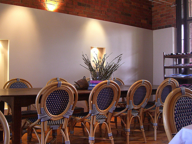

In [82]:
example = ds[0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

Let's check its corresponding caption:

In [83]:
example["text"]

'Sebuah restoran memiliki meja dan kursi kayu modern.'

## Create PyTorch Dataset

Next, we create a standard [PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). Each item of the dataset returns the expected inputs for the model, in this case input_ids, attention_mask and pixel_values.

We use `GitProcessor` to turn each (image, text) pair into the expected inputs. Basically, the text gets turned into `input_ids` and `attention_mask`, and the image gets turned into `pixel_values`.

In [98]:
from torch.utils.data import Dataset

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")

        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        return encoding

In [70]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("microsoft/git-base")

In [99]:
train_dataset = ImageCaptioningDataset(ds, processor)

Let's check one example of the dataset:

In [100]:
item = train_dataset[0]
for k,v in item.items():
  print(k,v.shape)

input_ids torch.Size([512])
attention_mask torch.Size([512])
pixel_values torch.Size([3, 224, 224])


## Create PyTorch DataLoader

Next, we create a corresponding [PyTorch DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), which allows us to get batches of data from the dataset.

We need this as neural networks (like GIT) are trained on batches of data, using stochastic gradient descent (SGD).

In [101]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

In [102]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

input_ids torch.Size([2, 512])
attention_mask torch.Size([2, 512])
pixel_values torch.Size([2, 3, 224, 224])


Let's check one batch, and do some sanity checks. We can decode the input_ids back into text for instance:

In [103]:
processor.decode(batch["input_ids"][0])

'[CLS] sekelompok orang menerbangkan layang - layang di pantai. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

We can "denormalize" the pixel values to get back an image:

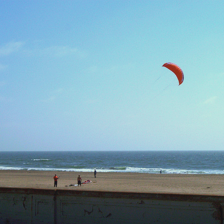

In [104]:
from PIL import Image
import numpy as np

MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255

unnormalized_image = (batch["pixel_values"][0].numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

Looks ok! Always important to check your data ;) see [this blog](http://karpathy.github.io/2019/04/25/recipe/) for a great overview of tips when training neural networks.

## Define model

Next, we instantiate a model. We start from the pre-trained GIT-base model (which was already pre-trained on 4 million image-text pairs by Microsoft).

Of course, feel free to start fine-tuning another GIT model from the [hub](https://huggingface.co/models?other=git).

In [105]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")

## Dummy forward pass

It's always good to check the initial loss on a batch. See also the blog above.

In [106]:
outputs = model(input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                pixel_values=batch["pixel_values"],
                labels=batch["input_ids"])
outputs.loss

tensor(12.2294, grad_fn=<NllLossBackward0>)

## Train the model

Next, let's train the model! We use native PyTorch here.

As I created a super tiny dataset just for demo purposes, we'll let the model overfit it. If it's capable of overfitting it (i.e. achieve zero loss), then that's a great way to know that everything is working properly. See also the blog above.

In [107]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(2):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss

    # print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
  print("Loss:", loss.item())

Epoch: 0
Loss: 12.30286693572998
Loss: 10.717371940612793
Loss: 10.177140235900879
Loss: 9.910733222961426
Loss: 9.674732208251953
Loss: 9.478826522827148
Loss: 9.247236251831055
Loss: 9.069621086120605
Loss: 8.904133796691895
Loss: 8.76221752166748
Loss: 8.639084815979004
Loss: 8.48271656036377
Loss: 8.400751113891602
Loss: 8.305281639099121
Loss: 8.150032997131348
Loss: 8.040225982666016
Loss: 7.967262268066406
Loss: 7.8557209968566895
Loss: 7.734012126922607
Loss: 7.642886638641357
Loss: 7.515795707702637
Loss: 7.457381248474121
Loss: 7.354558944702148
Loss: 7.268462181091309
Loss: 7.154933452606201
Loss: 7.0561604499816895
Loss: 6.9412713050842285
Loss: 6.868238925933838
Loss: 6.749239921569824
Loss: 6.680272102355957
Loss: 6.553038597106934
Loss: 6.412513256072998
Loss: 6.297152996063232
Loss: 6.273484230041504
Loss: 6.084867477416992
Loss: 5.977192401885986
Loss: 5.916910171508789
Loss: 5.8021931648254395
Loss: 5.7011919021606445
Loss: 5.57865047454834
Loss: 5.456124305725098
Los

KeyboardInterrupt: ignored

## Inference

Now that we've trained the model, let's load the Maradona image and perform inference on it.

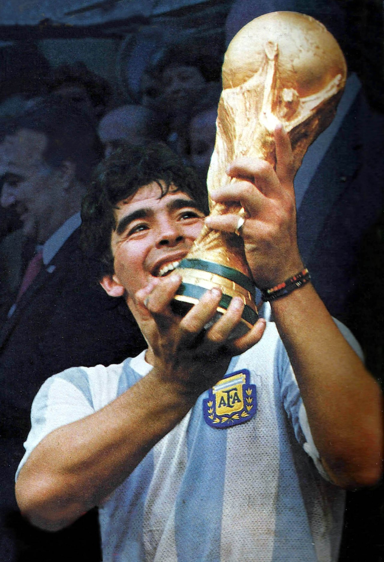

In [ ]:
# load image
example = dataset[0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

In [ ]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

maradona after winning the 1986 fifa world cup with argentina


Great! We've successfully fine-tuned GIT on our tiny (image, text) dataset to generate captions of images of football players.